In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import os
os.chdir('D://DKIT//dissertation//Dataset_of_Tomato_Leaves//plantvillage//Preprocessed_data//64//vector//')

In [3]:
#reading numpy array data
pixels = np.load('rgb_data.npy')
#reading csv file
data = pd.read_csv('rgb_data.csv')

In [4]:
features = pd.DataFrame(pixels)
features = features.values

In [5]:
features

array([[143, 147, 146, ..., 123, 113, 112],
       [178, 172, 172, ..., 138, 124, 123],
       [125, 129, 106, ...,  61,  53,  51],
       ...,
       [130, 115, 118, ..., 127, 127, 129],
       [179, 168, 176, ..., 126, 113, 122],
       [114,  99, 102, ..., 205, 191, 188]], dtype=uint8)

In [6]:
target = data['disease']

In [7]:
cat = target.unique()

In [8]:
vals = list(range(0,10))

In [9]:
for i in range(0,10):
    target.replace(to_replace=cat[i],value = vals[i],inplace = True)

In [10]:
target

0        0
1        0
2        0
3        0
4        0
        ..
14526    9
14527    9
14528    9
14529    9
14530    9
Name: disease, Length: 14531, dtype: int64

In [11]:
target = target.values

In [12]:
target = target.reshape(14531, 1)

In [13]:
target

array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]], dtype=int64)

In [14]:
#splitting the data to test and train
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(features,target, test_size=0.20, random_state=24)

In [15]:
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

In [16]:
xtrain = xtrain.reshape(xtrain.shape[0], 64, 64, 3)
xtest = xtest.reshape(xtest.shape[0], 64, 64, 3)

In [17]:
xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')

In [18]:
# normalizing the data to help with the training
xtrain /= 255
xtest /= 255

In [19]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
ytrain = np_utils.to_categorical(ytrain, n_classes)
ytest = np_utils.to_categorical(ytest, n_classes)

In [20]:
# building a linear stack of layers with the sequential model
gray_cnn_model = Sequential()

# convolutional layer 1
gray_cnn_model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(64, 64, 3)))

# convolutional layer 2
gray_cnn_model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
gray_cnn_model.add(MaxPool2D(pool_size=(2,2)))
gray_cnn_model.add(Dropout(0.25))
# convolutional layer 3
gray_cnn_model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
gray_cnn_model.add(MaxPool2D(pool_size=(2,2)))
gray_cnn_model.add(Dropout(0.25))

# flatten output of conv
gray_cnn_model.add(Flatten())

# hidden layer
gray_cnn_model.add(Dense(500, activation='relu'))
gray_cnn_model.add(Dropout(0.4))
gray_cnn_model.add(Dense(250, activation='relu'))
gray_cnn_model.add(Dropout(0.3))
# output layer
gray_cnn_model.add(Dense(10, activation='softmax'))

# compiling the sequential model
gray_cnn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [21]:
gray_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 50)        1400      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 75)        33825     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 75)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 75)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 125)       84500     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 125)      0         
 2D)                                                    

In [22]:
# training the model for 10 epochs
test_run = gray_cnn_model.fit(xtrain, ytrain, epochs=5, validation_data=(xtest, ytest))

Epoch 1/5
364/364 [==============================] - 185s 505ms/step - loss: 1.3059 - accuracy: 0.5502 - val_loss: 0.6556 - val_accuracy: 0.7895
Epoch 2/5
364/364 [==============================] - 194s 532ms/step - loss: 0.6316 - accuracy: 0.7866 - val_loss: 0.4253 - val_accuracy: 0.8555
Epoch 3/5
364/364 [==============================] - 185s 508ms/step - loss: 0.4721 - accuracy: 0.8381 - val_loss: 0.3581 - val_accuracy: 0.8813
Epoch 4/5
364/364 [==============================] - 201s 553ms/step - loss: 0.3897 - accuracy: 0.8703 - val_loss: 0.3723 - val_accuracy: 0.8717
Epoch 5/5
364/364 [==============================] - 200s 550ms/step - loss: 0.3213 - accuracy: 0.8891 - val_loss: 0.2660 - val_accuracy: 0.9092


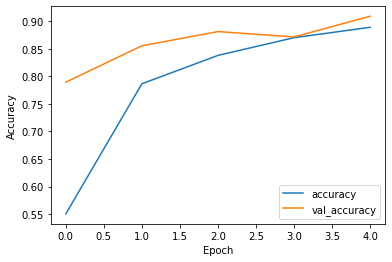

In [23]:
import matplotlib.pyplot as plt
plt.plot(test_run.history['accuracy'], label='accuracy')
plt.plot(test_run.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
score = gray_cnn_model.evaluate(xtest, ytest, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.2659724950790405
Test accuracy: 0.9091847538948059


In [25]:
pred = gray_cnn_model.predict(xtest) 
pred = np.argmax(pred, axis = 1)
label = np.argmax(ytest,axis = 1)

91/91 [==============================] - 10s 112ms/step


In [26]:
#importing classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
categories = []
for i in cat:
    i = i.replace('_',' ')
    categories.append(i)

In [33]:
categories

['bacterial spot',
 'early blight',
 'healthy',
 'late blight',
 'leaf mold',
 'septoria leaf spot',
 'target spot',
 'tomato mosaic virus',
 'tomato yellow leaf curl virus',
 'two-spotted spider mite']

In [35]:
print(classification_report(label, pred,target_names = categories))
print(confusion_matrix(label, pred))

                               precision    recall  f1-score   support

               bacterial spot       0.89      0.97      0.93       345
                 early blight       0.81      0.42      0.56       153
                      healthy       0.98      0.95      0.96       234
                  late blight       0.78      0.94      0.85       309
                    leaf mold       0.95      0.70      0.80       145
           septoria leaf spot       0.86      0.83      0.85       293
                  target spot       0.89      0.90      0.89       240
          tomato mosaic virus       0.73      1.00      0.84        54
tomato yellow leaf curl virus       0.97      0.98      0.98       854
      two-spotted spider mite       0.98      0.99      0.98       280

                     accuracy                           0.91      2907
                    macro avg       0.88      0.87      0.86      2907
                 weighted avg       0.91      0.91      0.90      2907

[[3

In [36]:
cm = confusion_matrix(label, pred)

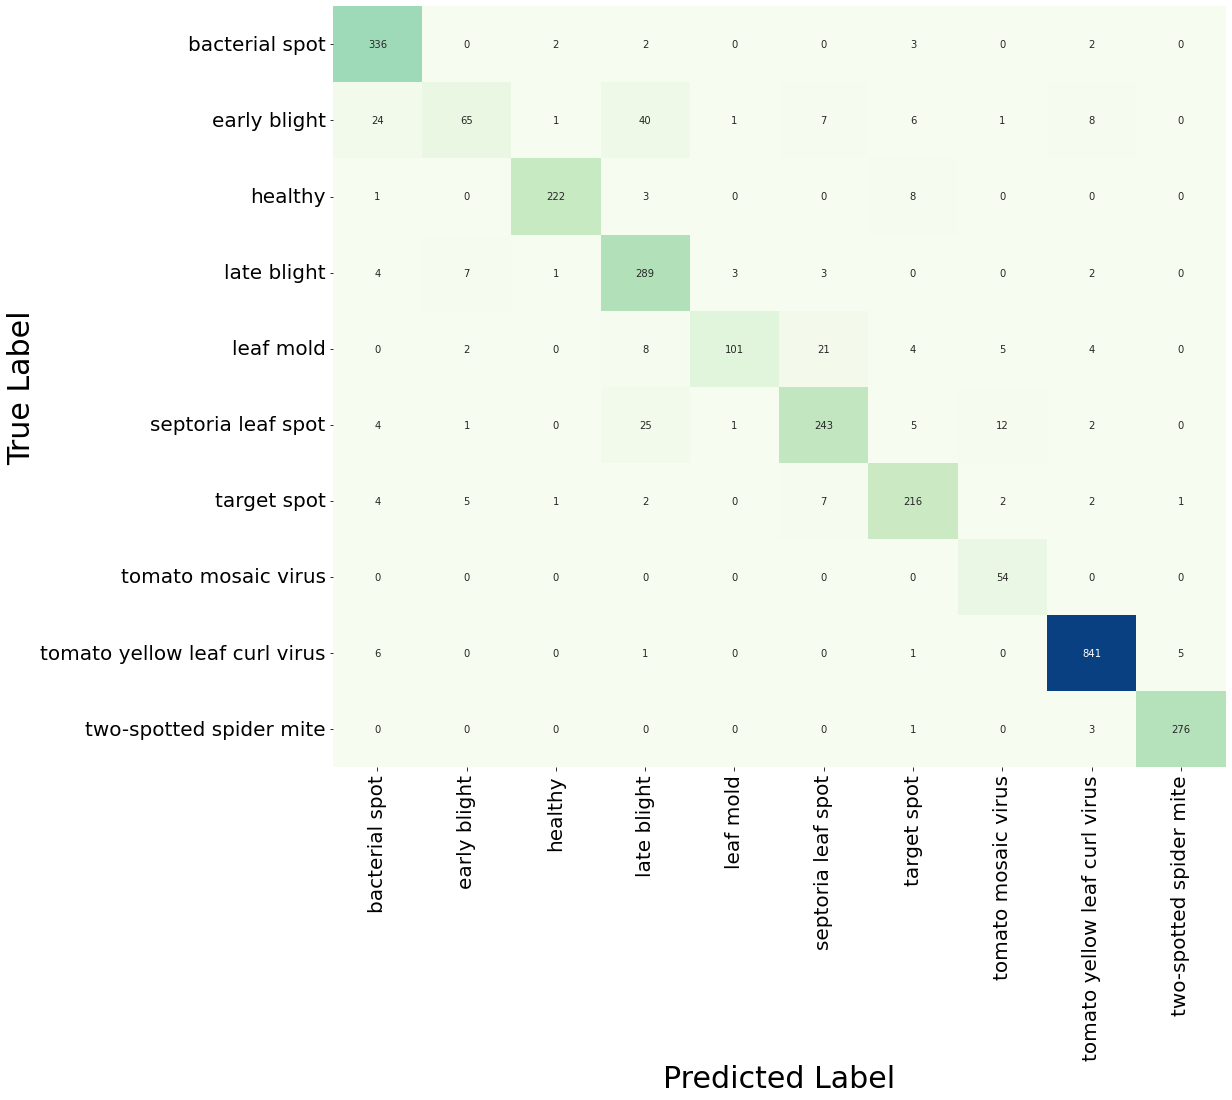

In [39]:
import seaborn as sn
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sn.heatmap(cm, annot=True, ax = ax, fmt = '', cmap = 'GnBu', cbar = False); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted Label', fontsize=30)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(categories, fontsize = 20)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Label', fontsize=30)
ax.yaxis.set_ticklabels(categories, fontsize = 20)
plt.yticks(rotation=0)
plt.show()